In [1]:
# ----------------------------------------
# 1. GPU 屏蔽设置(对于两块适配不同cuada版本gpu使用，此部分可删去)
# ----------------------------------------
# 必须在 import torch 之前运行
# 参照 run_cifar10_snn 文件中的配置
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [2]:
# ----------------------------------------
# 2. 导入库并检查环境
# ----------------------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import time
import numpy as np
import matplotlib.pyplot as plt

# 导入 SpikingJelly 核心库
from spikingjelly.activation_based import neuron, functional, layer

# 导入 CIFAR10-DVS 数据集加载器
from spikingjelly.datasets.cifar10_dvs import CIFAR10DVS

# 导入 自定义的替代梯度函数
import my_surrogates

# 检查环境 (与 run_cifar10_snn 相同)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Current device: {torch.cuda.get_device_name(0)}")
    print(f"Device count: {torch.cuda.device_count()}")

PyTorch version: 2.9.1+cu128
CUDA available: True
Current device: NVIDIA GeForce RTX 3090
Device count: 1


In [3]:
# ----------------------------------------
# 3. 定义超参数和设置
# ----------------------------------------

T = 10            # 仿真总时长 / 帧数
BATCH_SIZE = 32   # 批处理大小 (DVS数据 128x128 较占显存, 酌情调小)
EPOCHS = 100       # 训练轮数 (仅为调试，后续增大到100+)
LR = 1e-3         # 学习率
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DATA_DIR = './CIFAR10DVS' # CIFAR10-DVS 数据集的根目录 (你 getandread 的位置)

print(f"--- 实验设置 ---")
print(f"设备 (DEVICE): {DEVICE}")
print(f"仿真时长/帧数 (T): {T}")
print(f"批大小 (BATCH_SIZE): {BATCH_SIZE}")
print(f"训练轮数 (EPOCHS): {EPOCHS}")
print(f"数据路径 (DATA_DIR): {DATA_DIR}")
print(f"------------------\n")

--- 实验设置 ---
设备 (DEVICE): cuda:0
仿真时长/帧数 (T): 10
批大小 (BATCH_SIZE): 32
训练轮数 (EPOCHS): 100
数据路径 (DATA_DIR): ./CIFAR10DVS
------------------



In [4]:
# ----------------------------------------
# 4. 加载和预处理 CIFAR10-DVS 数据集
# ----------------------------------------
from torch.utils.data import random_split

print("正在加载 CIFAR10-DVS 数据集 (npz 格式)...")

# 定义一个转换，将 (T, C, H, W) 的 numpy 数组转换为 float tensor
# CIFAR10DVS 加载器会返回 [T, 2, 128, 128] 的 numpy 数组
class ToFloatTensor(object):
    def __call__(self, x):
        return torch.tensor(x, dtype=torch.float32)

# 1. 加载数据集
dataset = CIFAR10DVS(
    root=DATA_DIR,
    data_type='frame',
    frames_number=T,
    split_by='number',  # 按事件数量N均分
    transform=ToFloatTensor() # 应用转换
)

print(f"数据集总样本数: {len(dataset)}")


train_len = 9000
test_len = len(dataset) - train_len

# 使用 random_split 进行分割
# 设置 generator 和 manual_seed 以保证每次划分一致
train_dataset, test_dataset = random_split(
    dataset=dataset,
    lengths=[train_len, test_len],
    generator=torch.Generator().manual_seed(0) # 固定随机种子
)

# 3. 创建 DataLoaders
# 注意：num_workers 在 Windows/macOS 上可能需要设为 0
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print("数据集加载并划分完毕。")
print(f"训练集样本数: {len(train_dataset)}")
print(f"测试集样本数: {len(test_dataset)}")

正在加载 CIFAR10-DVS 数据集 (npz 格式)...
The directory [./CIFAR10DVS/frames_number_10_split_by_number] already exists.
数据集总样本数: 10000
数据集加载并划分完毕。
训练集样本数: 9000
测试集样本数: 1000


In [5]:
# ----------------------------------------
# 5. 定义 DVS 卷积 SNN 模型 (更新：调整alpha，层归一，dropout)
# ----------------------------------------

class DVS_CSNN(nn.Module):
    def __init__(self, T):
        super().__init__()
        self.T = T
        # 保持上次修正的 alpha=10.0，
        self.surrogate_grad = my_surrogates.SuperSpike(alpha=10.0) 
        
        # 定义网络结构
        self.net = nn.Sequential(
            # --- 块 1 ---
            layer.Conv2d(2, 32, kernel_size=3, padding=1), 
            layer.BatchNorm2d(32), 
            neuron.LIFNode(surrogate_function=self.surrogate_grad),
            layer.AvgPool2d(2), 
            layer.Dropout2d(p=0.5), # <-- NEW: 降低过拟合

            # --- 块 2 ---
            layer.Conv2d(32, 64, kernel_size=3, padding=1),
            layer.BatchNorm2d(64), 
            neuron.LIFNode(surrogate_function=self.surrogate_grad),
            layer.AvgPool2d(2), 
            layer.Dropout2d(p=0.5), # <-- NEW: 降低过拟合
            
            # --- 块 3 ---
            layer.Conv2d(64, 128, kernel_size=3, padding=1),
            layer.BatchNorm2d(128), 
            neuron.LIFNode(surrogate_function=self.surrogate_grad),
            layer.AvgPool2d(2), 
            layer.Dropout2d(p=0.5), # <-- NEW: 降低过拟合

            # --- 块 4 ---
            layer.Conv2d(128, 128, kernel_size=3, padding=1),
            layer.BatchNorm2d(128), 
            neuron.LIFNode(surrogate_function=self.surrogate_grad),
            layer.AvgPool2d(2), 
            layer.Dropout2d(p=0.5), # <-- NEW: 降低过拟合

            # --- 展平 ---
            layer.Flatten(),

            # --- 全连接层 1 ---
            layer.Linear(128 * 8 * 8, 256),
            layer.BatchNorm1d(256),
            neuron.LIFNode(surrogate_function=self.surrogate_grad),
            nn.Dropout(p=0.5), # <-- NEW: 降低过拟合 (1D)

            # --- 输出层 (10个类别) ---
            layer.Linear(256, 10)
        )
        
    def forward(self, x):
        # x 的输入维度是 [N, T, C, H, W]
        functional.reset_net(self)
        outputs_over_time = []
        
        for t in range(self.T):
            x_t = x[:, t, :, :, :]
            out_t = self.net(x_t)
            outputs_over_time.append(out_t)

        outputs_stack = torch.stack(outputs_over_time, dim=0)
        return outputs_stack.mean(dim=0)

In [6]:
# ----------------------------------------
# 6. 实例化模型、损失函数和优化器
# ----------------------------------------

model = DVS_CSNN(T).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

print(f"模型已创建并移动到 {DEVICE}")

模型已创建并移动到 cuda:0


In [7]:
# ----------------------------------------
# 7. 定义训练和测试函数 (与 run_cifar10_snn 相同)
# ----------------------------------------

# --- 训练函数 (Train Loop) ---
def train_epoch(model, epoch):
    model.train() # 设置为训练模式
    start_time = time.time()
    total_loss = 0.0
    correct = 0
    total = 0
    
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        # 1. 梯度清零
        optimizer.zero_grad()

        # 2. 前向传播
        # model.forward() 内部会处理 T 步循环并返回 (N, 10) 的平均输出
        outputs = model(inputs)

        # 3. 计算损失
        loss = criterion(outputs, targets)

        # 4. 反向传播和优化
        loss.backward()
        optimizer.step()

        # 统计损失和准确率
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        # 打印进度 (DVS 数据集较小, 每 20 批打印一次)
        #if (i + 1) % 50 == 0 or (i + 1) == len(train_loader):
            #print(f"  [Epoch {epoch}/{EPOCHS}, Batch {i + 1}/{len(train_loader)}] Loss: {loss.item():.4f}")

    end_time = time.time()
    avg_loss = total_loss / len(train_loader)
    acc = 100. * correct / total
    print(f"Epoch {epoch} 训练完成。用时: {end_time - start_time:.2f}秒")
    print(f"  训练集平均 Loss: {avg_loss:.4f}, 训练集准确率: {acc:.2f}%")
    return avg_loss, acc

# --- 评估函数 (Test Loop) ---
def test_epoch(model, epoch):
    model.eval() # 设置为评估模式
    total_loss = 0.0
    correct = 0
    total = 0

    # 评估时不需要计算梯度
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            # 前向传播
            outputs = model(inputs)

            # 计算损失
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            # 统计准确率
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    avg_loss = total_loss / len(test_loader)
    acc = 100. * correct / total
    #print(f"--- Epoch {epoch} 测试结果 ---")
    print(f"  测试集 Loss: {avg_loss:.4f}, 测试集准确率 (Acc): {acc:.2f}%")
    #print("--------------------------\n")
    return avg_loss, acc

In [ ]:
# ----------------------------------------
# 8. 开始训练
# ----------------------------------------
print("=== 开始训练 (CIFAR10-DVS) ===")

best_acc = 0.0
train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

for epoch in range(1, EPOCHS + 1):
    # 训练
    train_loss, train_acc = train_epoch(model, epoch)
    
    # 测试
    test_loss, test_acc = test_epoch(model, epoch)
    
    # 记录历史数据
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)
    
    # 保存最佳模型
    if test_acc > best_acc:
        best_acc = test_acc
        # torch.save(model.state_dict(), 'cifar10dvs_snn_best.pth')
        # print(f"*** 已保存新的最佳模型 (Acc: {best_acc:.2f}%) ***")

print("\n=== 训练完成 ===")
print(f"在 {EPOCHS} 轮训练后，最佳测试集准确率为: {best_acc:.2f}%")

=== 开始训练 (CIFAR10-DVS) ===
Epoch 1 训练完成。用时: 37.56秒
  训练集平均 Loss: 2.2437, 训练集准确率: 16.32%
  测试集 Loss: 2.2835, 测试集准确率 (Acc): 13.20%
Epoch 2 训练完成。用时: 35.15秒
  训练集平均 Loss: 2.2012, 训练集准确率: 18.27%
  测试集 Loss: 2.2347, 测试集准确率 (Acc): 14.30%
Epoch 3 训练完成。用时: 36.48秒
  训练集平均 Loss: 2.1613, 训练集准确率: 20.31%
  测试集 Loss: 2.1581, 测试集准确率 (Acc): 18.50%
Epoch 4 训练完成。用时: 36.63秒
  训练集平均 Loss: 2.1118, 训练集准确率: 22.62%
  测试集 Loss: 2.1413, 测试集准确率 (Acc): 20.90%
Epoch 5 训练完成。用时: 36.90秒
  训练集平均 Loss: 2.0473, 训练集准确率: 25.48%
  测试集 Loss: 2.0557, 测试集准确率 (Acc): 24.20%
Epoch 6 训练完成。用时: 36.93秒
  训练集平均 Loss: 1.9977, 训练集准确率: 27.20%
  测试集 Loss: 2.0566, 测试集准确率 (Acc): 26.00%
Epoch 7 训练完成。用时: 37.13秒
  训练集平均 Loss: 1.9676, 训练集准确率: 28.70%
  测试集 Loss: 1.9682, 测试集准确率 (Acc): 29.30%
Epoch 8 训练完成。用时: 37.04秒
  训练集平均 Loss: 1.9326, 训练集准确率: 30.16%
  测试集 Loss: 2.0099, 测试集准确率 (Acc): 26.80%
Epoch 9 训练完成。用时: 37.25秒
  训练集平均 Loss: 1.8951, 训练集准确率: 31.51%
  测试集 Loss: 1.9314, 测试集准确率 (Acc): 31.00%
Epoch 10 训练完成。用时: 37.32秒
  训练集平均 Loss: 1.8663, 训练集准确率: 

/tmp/ipykernel_49563/3796718191.py:24: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_49563/3796718191.py:24: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_49563/3796718191.py:24: UserWarning: Glyph 38598 (\N{CJK UNIFIED IDEOGRAPH-96C6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_49563/3796718191.py:24: UserWarning: Glyph 19982 (\N{CJK UNIFIED IDEOGRAPH-4E0E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_49563/3796718191.py:24: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_49563/3796718191.py:24: UserWarning: Glyph 35797 (\N{CJK UNIFIED IDEOGRAPH-8BD5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_49563/3796718191.py:24: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAP

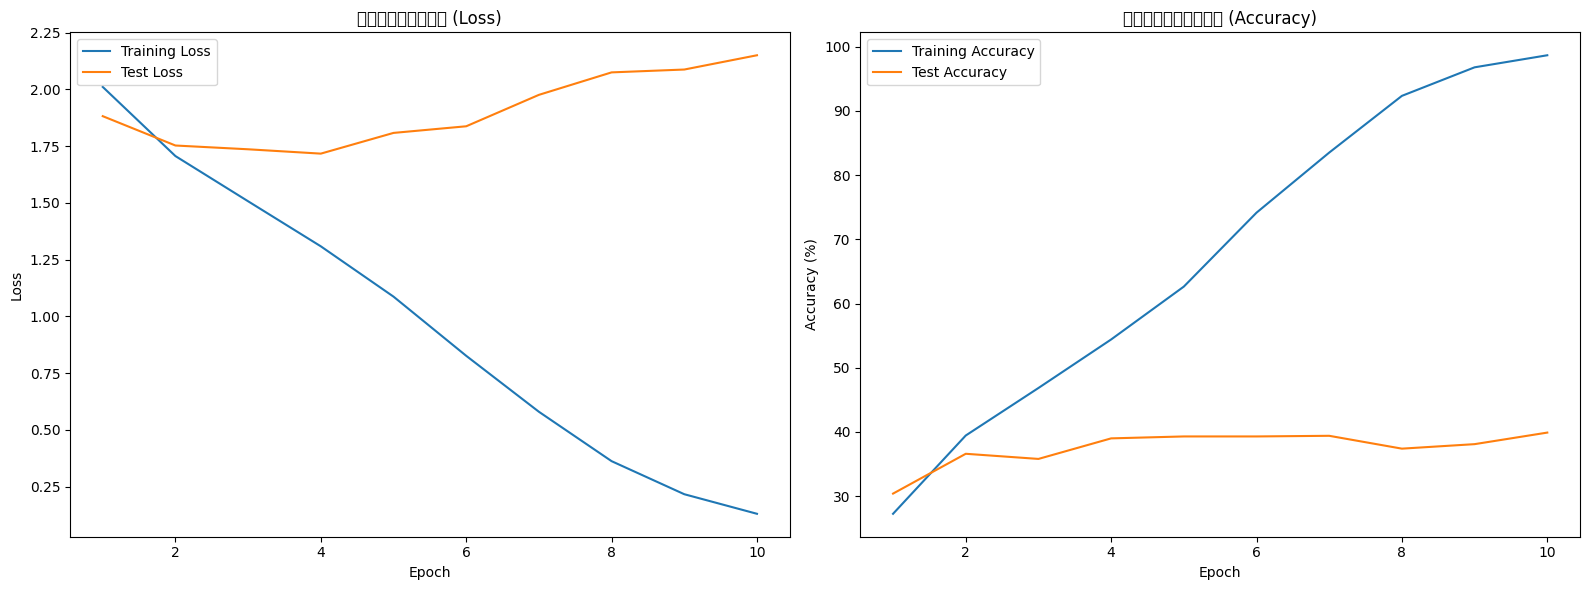

In [ ]:
# ----------------------------------------
# 9. 可视化结果
# ----------------------------------------
plt.figure(figsize=(16, 6))

# 损失曲线
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), train_loss_history, label='Training Loss')
plt.plot(range(1, EPOCHS + 1), test_loss_history, label='Test Loss')
plt.title("train and test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# 准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), train_acc_history, label='Training Accuracy')
plt.plot(range(1, EPOCHS + 1), test_acc_history, label='Test Accuracy')
plt.title("train and test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()